# Analyzing Training, Validation, and Testing Sets
Plotting some distributions of the test set.

In [2]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
import os
import h5py
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from functools import reduce

In [4]:
# Add the path to the parent directory to augment search for module
par_dir = os.pardir

if par_dir not in sys.path:
    print("adding pardir")
    sys.path.append(par_dir)
    sys.path.append("../..")

from short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

adding pardir


## Load Data

In [5]:
# Import test events from h5 file

original_data_path = "/data/WatChMaL/data/IWCD_mPMT_Short_e-mu-gamma_E0to1000MeV_digihits.h5"
data_file = h5py.File(original_data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(original_data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(original_data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(original_data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

#original_radius = [np.sqrt(original_positions[i,0,0]**2 + original_positions[i,0,2]**2) for i in range(original_positions.shape[0])]


<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


## Split Datasets

In [6]:
idxs_path = '/home/jtindall/WatChMaL_analysis/short_tank_exploratory_data_analysis/new_dataset/new_dataset_data/equal_indices.npz'
idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

In [7]:
train_angles    = angles[train_idxs]
train_energies  = energies[train_idxs]
train_positions = positions[train_idxs]
train_labels    = labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[val_idxs]
val_energies   = energies[val_idxs]
val_positions  = positions[val_idxs]
val_labels     = labels[val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 'angles':test_angles, 'labels':test_labels}

print("Done test info")

Done train info
Done val info
Done test info


In [8]:
# compute event radii
"""
train_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]
val_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]
test_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]

np.savez('./new_dataset_data/event_radii.npz', train_radii=train_info['radius'], val_radii=val_info['radius'], test_radii=test_info['radius'])
"""

radii_data = np.load('./new_dataset_data/event_radii.npz', allow_pickle=True)

train_info['radius'] = radii_data['train_radii']
val_info['radius']   = radii_data['val_radii']
test_info['radius']  = radii_data['test_radii']

In [9]:
dataset_info = [train_info, val_info, test_info]

In [10]:
# get indices associated with each dataset and particle type
train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

# Initialize Detector Geometry Parameters

In [11]:
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

In [12]:
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26

In [13]:
shifted_energies = []
for idx in range(3):
    shifted_energies.append(np.zeros(dataset_info[idx]['labels'].shape[0]))
    
    g_idxs = np.where(dataset_info[idx]['labels']==0)[0]
    e_idxs = np.where(dataset_info[idx]['labels']==1)[0]
    m_idxs = np.where(dataset_info[idx]['labels']==2)[0]
    
    shifted_energies[idx][g_idxs] = np.squeeze(dataset_info[idx]['energies'][g_idxs] - GAMMA_THRESHOLD)
    shifted_energies[idx][e_idxs] = np.squeeze(dataset_info[idx]['energies'][e_idxs] - ELECTRON_THRESHOLD)
    shifted_energies[idx][m_idxs] = np.squeeze(dataset_info[idx]['energies'][m_idxs] - MUON_THRESHOLD)

31
31
31
31


<Figure size 432x288 with 0 Axes>

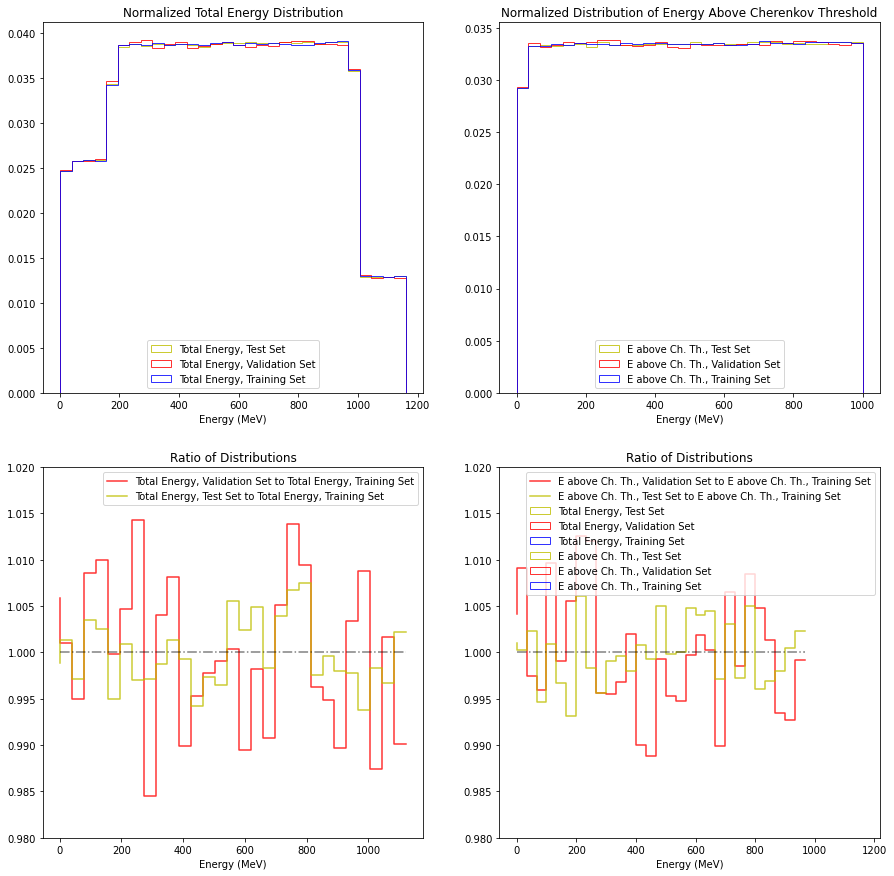

In [20]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()
ax = axes[0]

plot_compare_dists([np.squeeze(data['energies']) for data in dataset_info], 
                   numerator_dist_idxs   = [1,2],
                   denominator_dist_idxs   = [0,0],
                   bins=30,
                   labels=['Total Energy, {}'.format(data['name']) for data in dataset_info],
                   colors=('b','r','y'),
                   ratio_range=[0.98,1.02],
                   title='Normalized Total Energy Distribution',
                   xlabel='Energy (MeV)',
                   axes=axes[[0,2]],
                   loc='lower center'
                  )

plot_compare_dists([shifted_energies[i] for i in range(3)], 
                   [1,2],
                   [0,0],
                   bins=30,
                   labels=['E above Ch. Th., {}'.format(data['name']) for data in dataset_info],
                   colors=('b','r','y'),
                   ratio_range=[0.98,1.02],
                   title='Normalized Distribution of Energy Above Cherenkov Threshold',
                   xlabel='Energy (MeV)',axes=axes[[1,3]],
                   loc='lower center'
                  )

# Distribution of event energies by dataset and particle type

In [21]:
# get energies
train_e_energies = dataset_info[0]['energies'][train_e_idxs]
val_e_energies   = dataset_info[1]['energies'][val_e_idxs]
test_e_energies  = dataset_info[2]['energies'][test_e_idxs]

e_energies = np.concatenate((train_e_energies, val_e_energies, test_e_energies))

train_g_energies = dataset_info[0]['energies'][train_g_idxs]
val_g_energies   = dataset_info[1]['energies'][val_g_idxs]
test_g_energies  = dataset_info[2]['energies'][test_g_idxs]

g_energies = np.concatenate((train_g_energies, val_g_energies, test_g_energies))

train_m_energies = dataset_info[0]['energies'][train_m_idxs]
val_m_energies   = dataset_info[1]['energies'][val_m_idxs]
test_m_energies  = dataset_info[2]['energies'][test_m_idxs]


m_energies = np.concatenate((train_m_energies, val_m_energies, test_m_energies))

In [22]:
# get shifted energies
shifted_train_g_energies = shifted_energies[0][train_g_idxs]
shifted_val_g_energies   = shifted_energies[1][val_g_idxs]
shifted_test_g_energies  = shifted_energies[2][test_g_idxs]

shifted_g_energies = np.concatenate((shifted_train_g_energies, shifted_val_g_energies, shifted_test_g_energies))

shifted_train_e_energies = shifted_energies[0][train_e_idxs]
shifted_val_e_energies   = shifted_energies[1][val_e_idxs]
shifted_test_e_energies  = shifted_energies[2][test_e_idxs]

shifted_e_energies = np.concatenate((shifted_train_e_energies, shifted_val_e_energies, shifted_test_e_energies))

shifted_train_m_energies = shifted_energies[0][train_m_idxs]
shifted_val_m_energies   = shifted_energies[1][val_m_idxs]
shifted_test_m_energies  = shifted_energies[2][test_m_idxs]

shifted_m_energies = np.concatenate((shifted_train_m_energies, shifted_val_m_energies, shifted_test_m_energies))


41
41
41
41
41
41


../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  alpha=0.8,label='{} to {}'.format(labels[idx],labels[denominator_dist_idxs[i]]),
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  alpha=0.8,label='{} to {}'.format(labels[idx],labels[denominator_dist_idxs[i]]),
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  alpha=0.8,label='{} to {}'.format(labels[idx],labels[denominator_dist_idxs[i]]),
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:156: RuntimeWarning: invalid value encountered in true_divide
  alpha=0.8,label='{} to {}'.format(labels[idx],labels[denominator_dist_idxs[i]]),
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:156: RuntimeWarning: invalid v

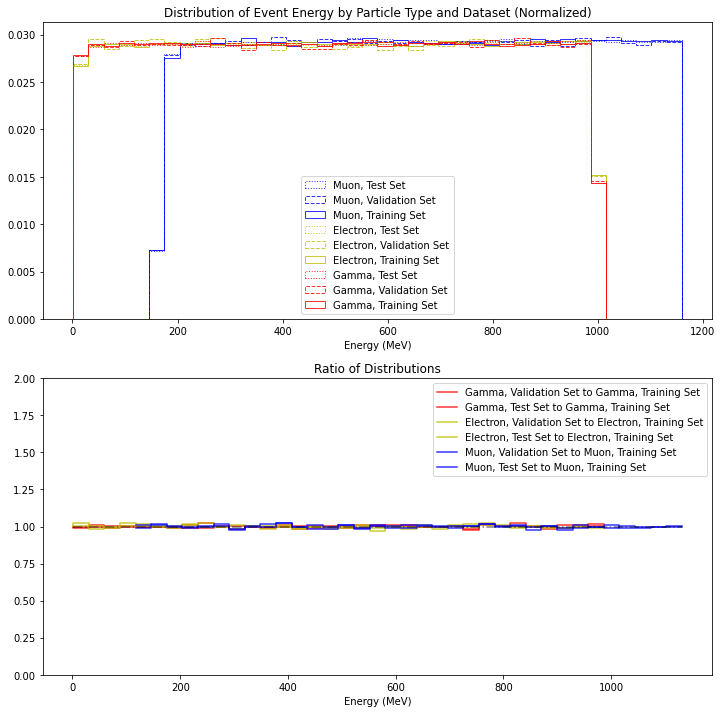

In [36]:
fig = plot_compare_dists([np.squeeze(train_e_energies), np.squeeze(val_e_energies), np.squeeze(test_e_energies), 
                          np.squeeze(train_g_energies), np.squeeze(val_g_energies), np.squeeze(test_g_energies),  
                          np.squeeze(train_m_energies), np.squeeze(val_m_energies), np.squeeze(test_m_energies)],
                         numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                         denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                         bins=40,
                         labels=[
                                  'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                  'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                  'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                         ratio_range=[0,2],
                         title='Distribution of Event Energy by Particle Type and Dataset (Normalized)', 
                         colors =  ['r','r','r','y','y','y','b','b','b'],
                         linestyle=['-','--',':','-','--',':','-','--',':'], 
                         xlabel='Energy (MeV)',
                         loc='lower center'
                    )


41
41
41
41
41
41


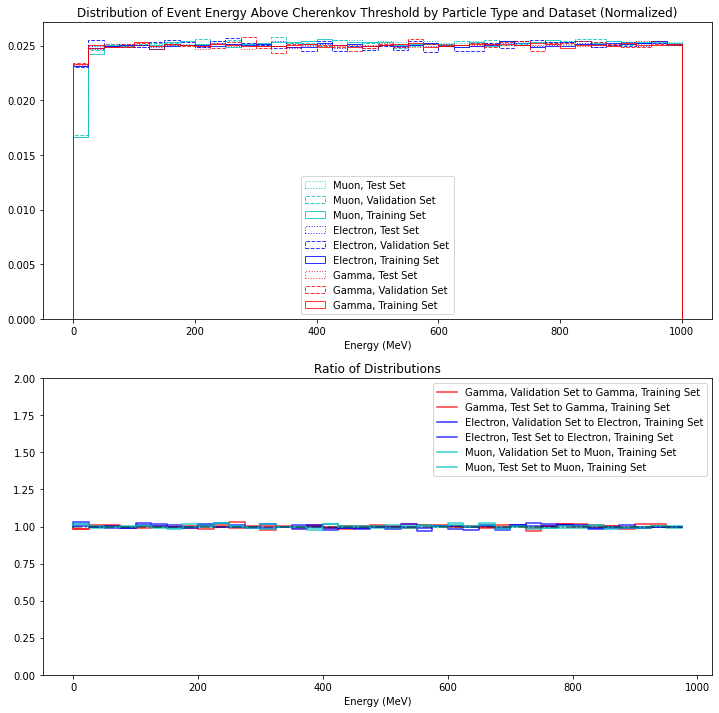

In [37]:
fig = plot_compare_dists([np.squeeze(shifted_train_e_energies), np.squeeze(shifted_val_e_energies), np.squeeze(shifted_test_e_energies), 
                          np.squeeze(shifted_train_g_energies), np.squeeze(shifted_val_g_energies), np.squeeze(shifted_test_g_energies),  
                          np.squeeze(shifted_train_m_energies), np.squeeze(shifted_val_m_energies), np.squeeze(shifted_test_m_energies)],
                          numerator_dist_idxs   = [1, 2, 4, 5, 7, 8],
                          denominator_dist_idxs = [0, 0, 3, 3, 6, 6],
                          bins=40,
                          labels=[
                                 'Gamma, Training Set', 'Gamma, Validation Set', 'Gamma, Test Set',
                                 'Electron, Training Set', 'Electron, Validation Set', 'Electron, Test Set',
                                 'Muon, Training Set', 'Muon, Validation Set', 'Muon, Test Set'],
                          ratio_range=[0,2],
                          title='Distribution of Event Energy Above Cherenkov Threshold by Particle Type and Dataset (Normalized)', colors=['r','r','r','b','b','b','c','c','c'],
                          linestyle=['-','--',':','-','--',':','-','--',':'], xlabel='Energy (MeV)',
                          loc='lower center'
                    )


# Distribution of event energies by particle type

In [39]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()
ax = axes[0]

plot_compare_dists([np.squeeze(e_energies), 
                    np.squeeze(g_energies), 
                    np.squeeze(m_energies)],
                   bins=30,
                   numerator_dist_idxs   = [],
                   denominator_dist_idxs = [],
                   labels=['Total Energy, {}'.format(name)for name in ['electron', 'gamma', 'muon']],
                   colors=('r','y','b'),
                   ratio_range=[0.98,1.02],
                   title='Normalized Total Energy Distribution',
                   xlabel='Energy (MeV)',axes=axes[[0,2]]
                  )

plot_compare_dists([np.squeeze(shifted_e_energies), 
                    np.squeeze(shifted_g_energies), 
                    np.squeeze(shifted_m_energies)],
                   bins=30,
                   numerator_dist_idxs   = [],
                   denominator_dist_idxs = [],
                   labels=['Total Energy, {}'.format(name)for name in ['electron', 'gamma', 'muon']],
                   colors=('r','y','b'),
                   ratio_range=[0.98,1.02],
                   title='Normalized Total Energy Distribution',
                   xlabel='Energy (MeV)',axes=axes[[1,3]]
                  )

No handles with labels found to put in legend.


# Distribution of total charge

In [16]:
"""
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Training Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
            ' ', ETA()], maxval=len(train_idxs))

pbar.start()
for i in range(len(train_idxs)):
    pbar.update(i)
    
    item = train_idxs[i]
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]
    charge = hit_charge[start:stop]
    
    total_charge.append(np.sum(charge))
pbar.finish()

dataset_info[0]['total_charge'] = np.array(total_charge)

np.savez('./new_dataset_data/training_set_total_charge.npz', total_charge=dataset_info[0]['total_charge'])
"""

"\ntotal_charge = []\n\npbar = ProgressBar(widgets=['Calculating Total Charge for Training Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n            ' ', ETA()], maxval=len(train_idxs))\n\npbar.start()\nfor i in range(len(train_idxs)):\n    pbar.update(i)\n    \n    item = train_idxs[i]\n    start = event_hits_index[item]\n    stop  = event_hits_index[item + 1]\n    charge = hit_charge[start:stop]\n    \n    total_charge.append(np.sum(charge))\npbar.finish()\n\ndataset_info[0]['total_charge'] = np.array(total_charge)\n\nnp.savez('./new_dataset_data/training_set_total_charge.npz', total_charge=dataset_info[0]['total_charge'])\n"

In [17]:
"""
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(val_idxs))

pbar.start()
for i in range(len(val_idxs)):
    pbar.update(i)
    
    item = val_idxs[i]
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]
    charge = hit_charge[start:stop]
    
    total_charge.append(np.sum(charge))
pbar.finish()

dataset_info[1]['total_charge'] = np.array(total_charge)

np.savez('./new_dataset_data/validation_set_total_charge.npz', total_charge=dataset_info[1]['total_charge'])
"""

"\ntotal_charge = []\n\npbar = ProgressBar(widgets=['Calculating Total Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=len(val_idxs))\n\npbar.start()\nfor i in range(len(val_idxs)):\n    pbar.update(i)\n    \n    item = val_idxs[i]\n    start = event_hits_index[item]\n    stop  = event_hits_index[item + 1]\n    charge = hit_charge[start:stop]\n    \n    total_charge.append(np.sum(charge))\npbar.finish()\n\ndataset_info[1]['total_charge'] = np.array(total_charge)\n\nnp.savez('./new_dataset_data/validation_set_total_charge.npz', total_charge=dataset_info[1]['total_charge'])\n"

In [18]:
dataset_info[0]['total_charge'] = np.load('./new_dataset_data/training_set_total_charge.npz',allow_pickle=True)['total_charge']
dataset_info[1]['total_charge'] = np.load('./new_dataset_data/validation_set_total_charge.npz',allow_pickle=True)['total_charge']

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

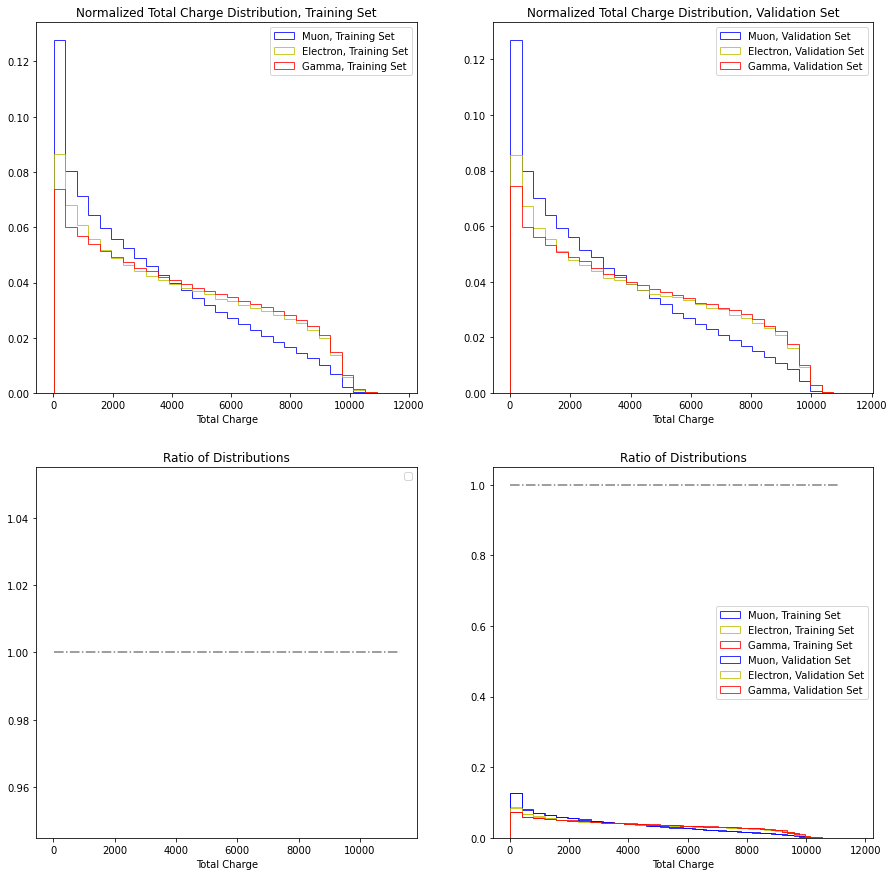

In [31]:
plt.figure()
fig,axes = plt.subplots(2,2,figsize=(15,15))
axes = axes.flatten()

N_BINS = 40
for i in range(2):
    g_idxs = np.where(dataset_info[i]['labels']==0)[0]
    e_idxs = np.where(dataset_info[i]['labels']==1)[0]
    m_idxs = np.where(dataset_info[i]['labels']==2)[0]
    
    plot_compare_dists(( dataset_info[i]['total_charge'][g_idxs],
                         dataset_info[i]['total_charge'][e_idxs],
                         dataset_info[i]['total_charge'][m_idxs]),
                         bins=30,
                         numerator_dist_idxs   = [],
                         denominator_dist_idxs = [], 
                         labels = [
                         'Gamma, {}'.format(dataset_info[i]['name']),
                         'Electron, {}'.format(dataset_info[i]['name']),
                         'Muon, {}'.format(dataset_info[i]['name'])],
                         colors=('r','y','b'),
                         axes = axes[[i,i+2]],
                         title='Normalized Total Charge Distribution, {}'.format(dataset_info[i]['name']),
                         xlabel='Total Charge'
                           )

../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


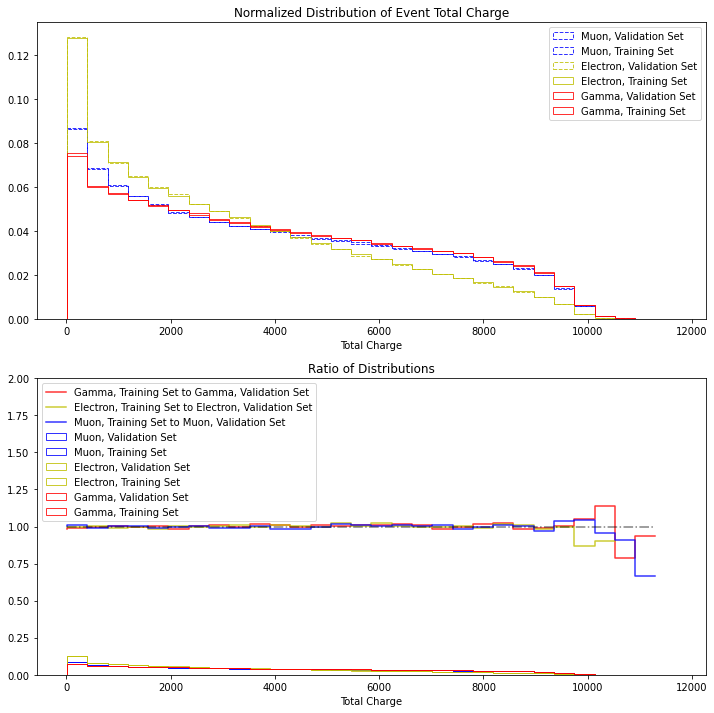

In [32]:
train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]

val_g_idxs = np.where(dataset_info[1]['labels']==0)[0]
val_e_idxs = np.where(dataset_info[1]['labels']==1)[0]
val_m_idxs = np.where(dataset_info[1]['labels']==2)[0]

fig = plot_compare_dists([
                    dataset_info[0]['total_charge'][train_g_idxs], dataset_info[1]['total_charge'][val_g_idxs],
                    dataset_info[0]['total_charge'][train_m_idxs], dataset_info[1]['total_charge'][val_m_idxs],
                    dataset_info[1]['total_charge'][val_e_idxs], dataset_info[0]['total_charge'][train_e_idxs]],
                    bins=30,
                    numerator_dist_idxs   = [0,2,4],
                    denominator_dist_idxs = [1,3,5],
                    labels= ['Gamma, Training Set', 'Gamma, Validation Set',
                             'Electron, Training Set', 'Electron, Validation Set',
                             'Muon, Training Set', 'Muon, Validation Set'],
                    ratio_range=[0,2],title='Normalized Distribution of Event Total Charge',
                    colors=['r','r','y','y','b','b'],
                    linestyle=['-','-','-','--','--','--'],
                    xlabel='Total Charge'
                    )


# High Resolution

../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],


"\n\nfig = plot_compare_dists([\n                    dataset_info[0]['total_charge'][left_train_g_idxs], dataset_info[1]['total_charge'][left_val_g_idxs],\n                    dataset_info[0]['total_charge'][left_train_e_idxs], dataset_info[1]['total_charge'][left_val_e_idxs],\n                    dataset_info[0]['total_charge'][left_train_m_idxs], dataset_info[1]['total_charge'][left_val_m_idxs]],\n                    [0,1,2],[3,4,5],['Gamma, Training Set', 'Electron, Training Set', 'Muon, Training Set',\n                                     'Gamma, Validation Set', 'Electron, Validation Set', 'Muon, Validation Set'],\n                    ratio_range=[0,2],title='Normalized Distribution of Event Total Charge',colors=['r','m','y','b','c','k'],\n                    linestyle=['-','-','-','--','--','--'],xlabel='Total Charge, 10^6',\n                    xscale='log'\n                    )\n"

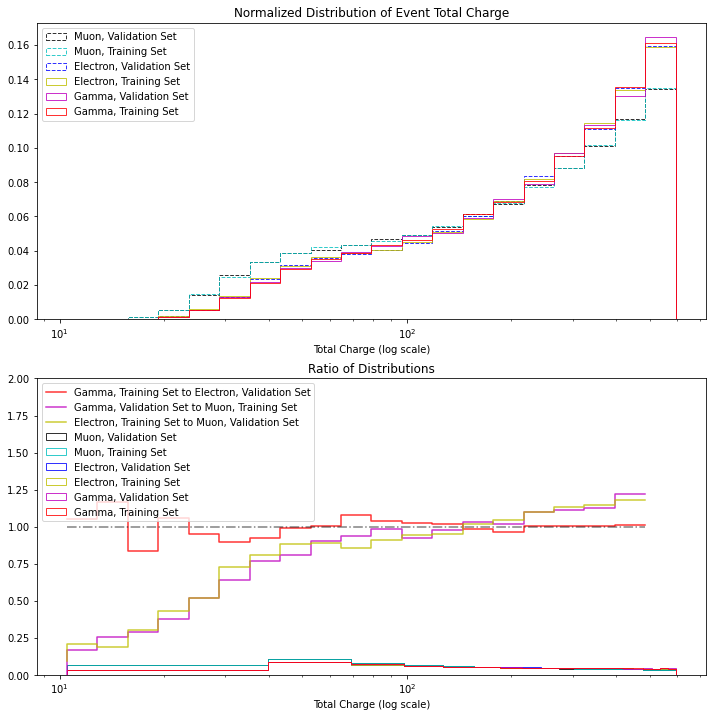

In [33]:
# Find all events in the leftmost bin
train_left_bin_bound = 5.94362375e02
left_train_g_idxs = train_g_idxs[dataset_info[0]['total_charge'][train_g_idxs] < train_left_bin_bound]
left_train_e_idxs = train_e_idxs[dataset_info[0]['total_charge'][train_e_idxs] < train_left_bin_bound]
left_train_m_idxs = train_m_idxs[dataset_info[0]['total_charge'][train_m_idxs] < train_left_bin_bound]

val_left_bin_bound = 5.94362375e02
left_val_g_idxs = val_g_idxs[dataset_info[1]['total_charge'][val_g_idxs] < val_left_bin_bound]
left_val_e_idxs = val_e_idxs[dataset_info[1]['total_charge'][val_e_idxs] < val_left_bin_bound]
left_val_m_idxs = val_m_idxs[dataset_info[1]['total_charge'][val_m_idxs] < val_left_bin_bound]


fig = plot_compare_dists([
                    dataset_info[0]['total_charge'][left_train_g_idxs], dataset_info[1]['total_charge'][left_val_g_idxs],
                    dataset_info[0]['total_charge'][left_train_e_idxs], dataset_info[1]['total_charge'][left_val_e_idxs],
                    dataset_info[0]['total_charge'][left_train_m_idxs], dataset_info[1]['total_charge'][left_val_m_idxs]],
                    [0,1,2],[3,4,5],['Gamma, Training Set', 'Gamma, Validation Set',
                                     'Electron, Training Set', 'Electron, Validation Set',
                                     'Muon, Training Set', 'Muon, Validation Set'],
                    ratio_range=[0,2],title='Normalized Distribution of Event Total Charge',colors=['r','m','y','b','c','k'],
                    linestyle=['-','-','-','--','--','--'],
                    xlabel='Total Charge (log scale)',
                    xscale='log',
                    loc='upper left'
                    )
"""

fig = plot_compare_dists([
                    dataset_info[0]['total_charge'][left_train_g_idxs], dataset_info[1]['total_charge'][left_val_g_idxs],
                    dataset_info[0]['total_charge'][left_train_e_idxs], dataset_info[1]['total_charge'][left_val_e_idxs],
                    dataset_info[0]['total_charge'][left_train_m_idxs], dataset_info[1]['total_charge'][left_val_m_idxs]],
                    [0,1,2],[3,4,5],['Gamma, Training Set', 'Electron, Training Set', 'Muon, Training Set',
                                     'Gamma, Validation Set', 'Electron, Validation Set', 'Muon, Validation Set'],
                    ratio_range=[0,2],title='Normalized Distribution of Event Total Charge',colors=['r','m','y','b','c','k'],
                    linestyle=['-','-','-','--','--','--'],xlabel='Total Charge, 10^6',
                    xscale='log'
                    )
"""

# Event Examination

In [34]:
from WatChMaL.analysis.plot_utils import get_plot_array

def get_event_data_from_index(item):
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]

    hit_pmts    = hit_pmt[start:stop].astype(np.int16)
    hit_charges = hit_charge[start:stop]
    hit_times   = hit_time[start:stop]

    hit_mpmts = hit_pmts // pmts_per_mpmt
    hit_pmt_in_modules = hit_pmts % pmts_per_mpmt

    hit_rows = mpmt_positions[hit_mpmts, 0]
    hit_cols = mpmt_positions[hit_mpmts, 1]

    sample_data = np.zeros(data_size)
    sample_data[hit_pmt_in_modules, hit_rows, hit_cols] = hit_charges

    # fix barrel array indexing to match endcaps in xyz ordering
    sample_data[:, 12:28, :] = sample_data[barrel_map_array_idxs, 12:28, :]
    moved_data = np.moveaxis(sample_data, 0, -1)
    return moved_data

In [35]:
left_train_event_indices = np.concatenate((left_train_g_idxs, left_train_e_idxs, left_train_m_idxs))
left_train_event_charges = np.concatenate((dataset_info[0]['total_charge'][left_train_g_idxs], 
                                           dataset_info[0]['total_charge'][left_train_e_idxs],
                                           dataset_info[0]['total_charge'][left_train_m_idxs]))

# get some random indices
#random_indices = np.random.choice(left_train_event_indices.shape[0], 5, replace=False)
#print(random_indices)
random_indices = [310867,  39009, 540224, 538982,   3266]

In [36]:
sample_event_indices = left_train_event_indices[random_indices]
sample_event_charges = left_train_event_charges[random_indices]

/home/jtindall/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  # This is added back by InteractiveShellApp.init_path()


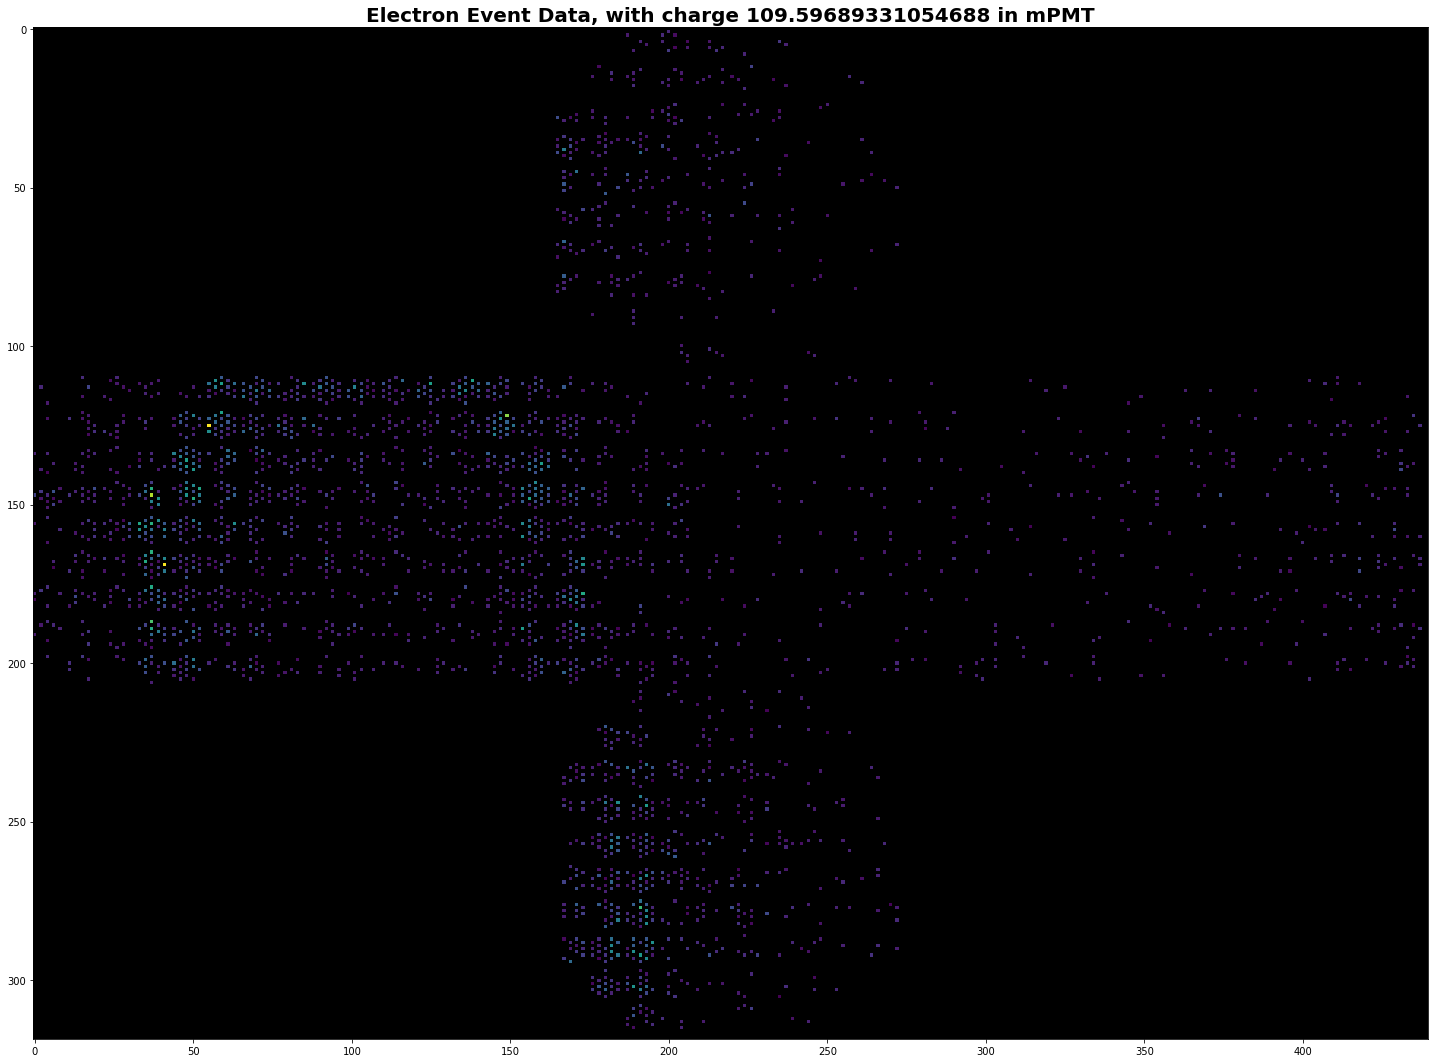

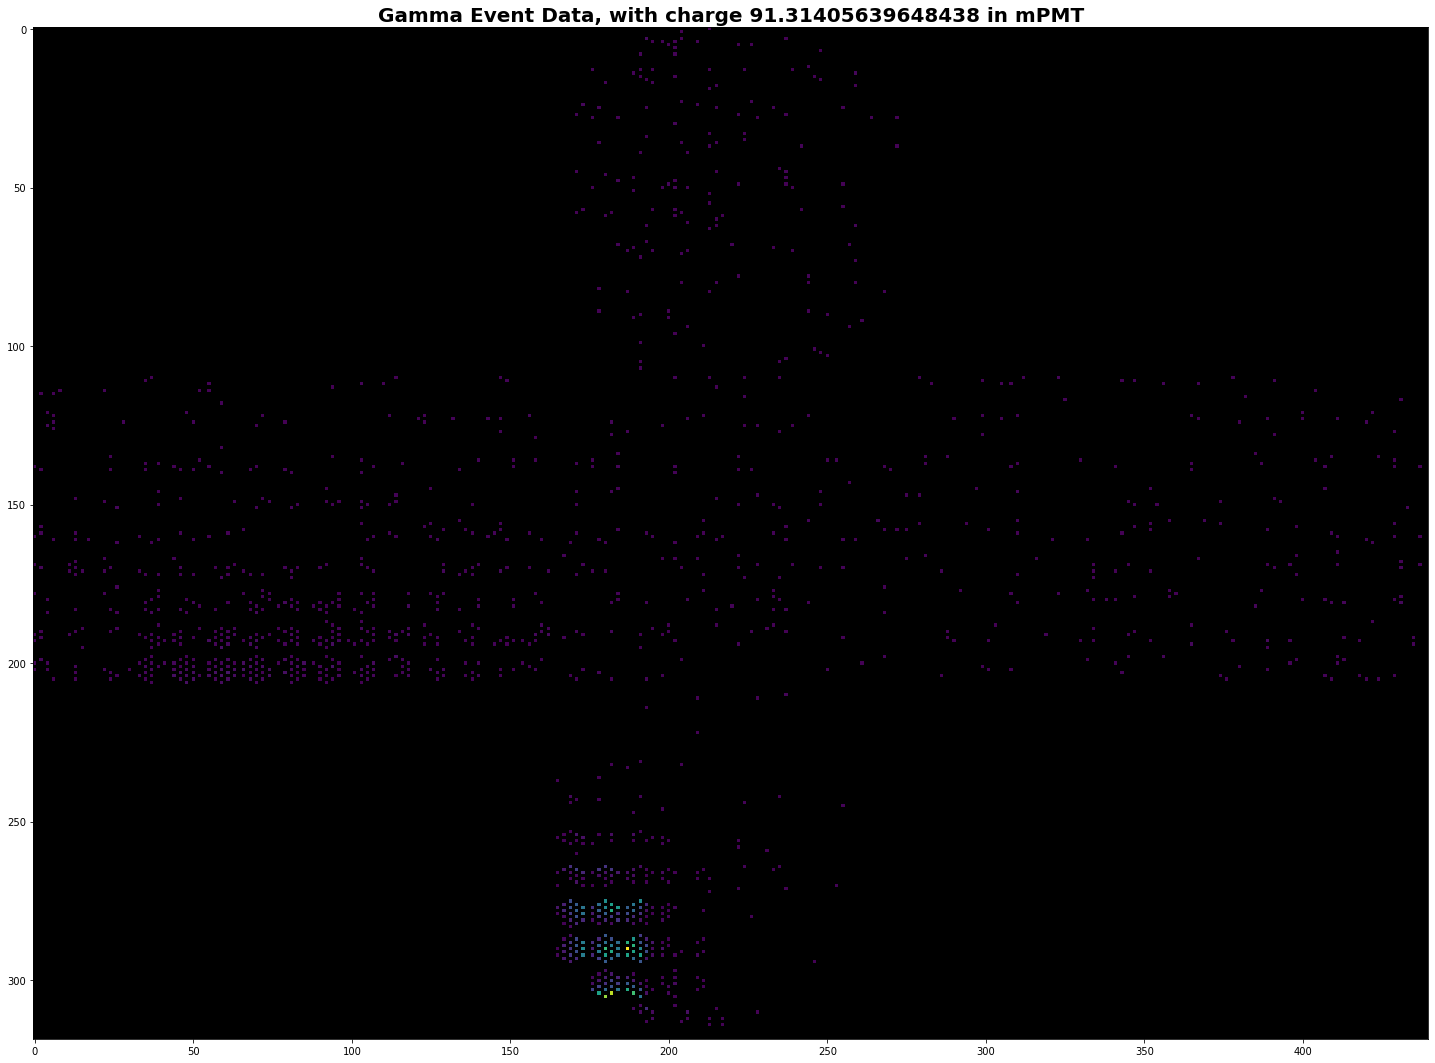

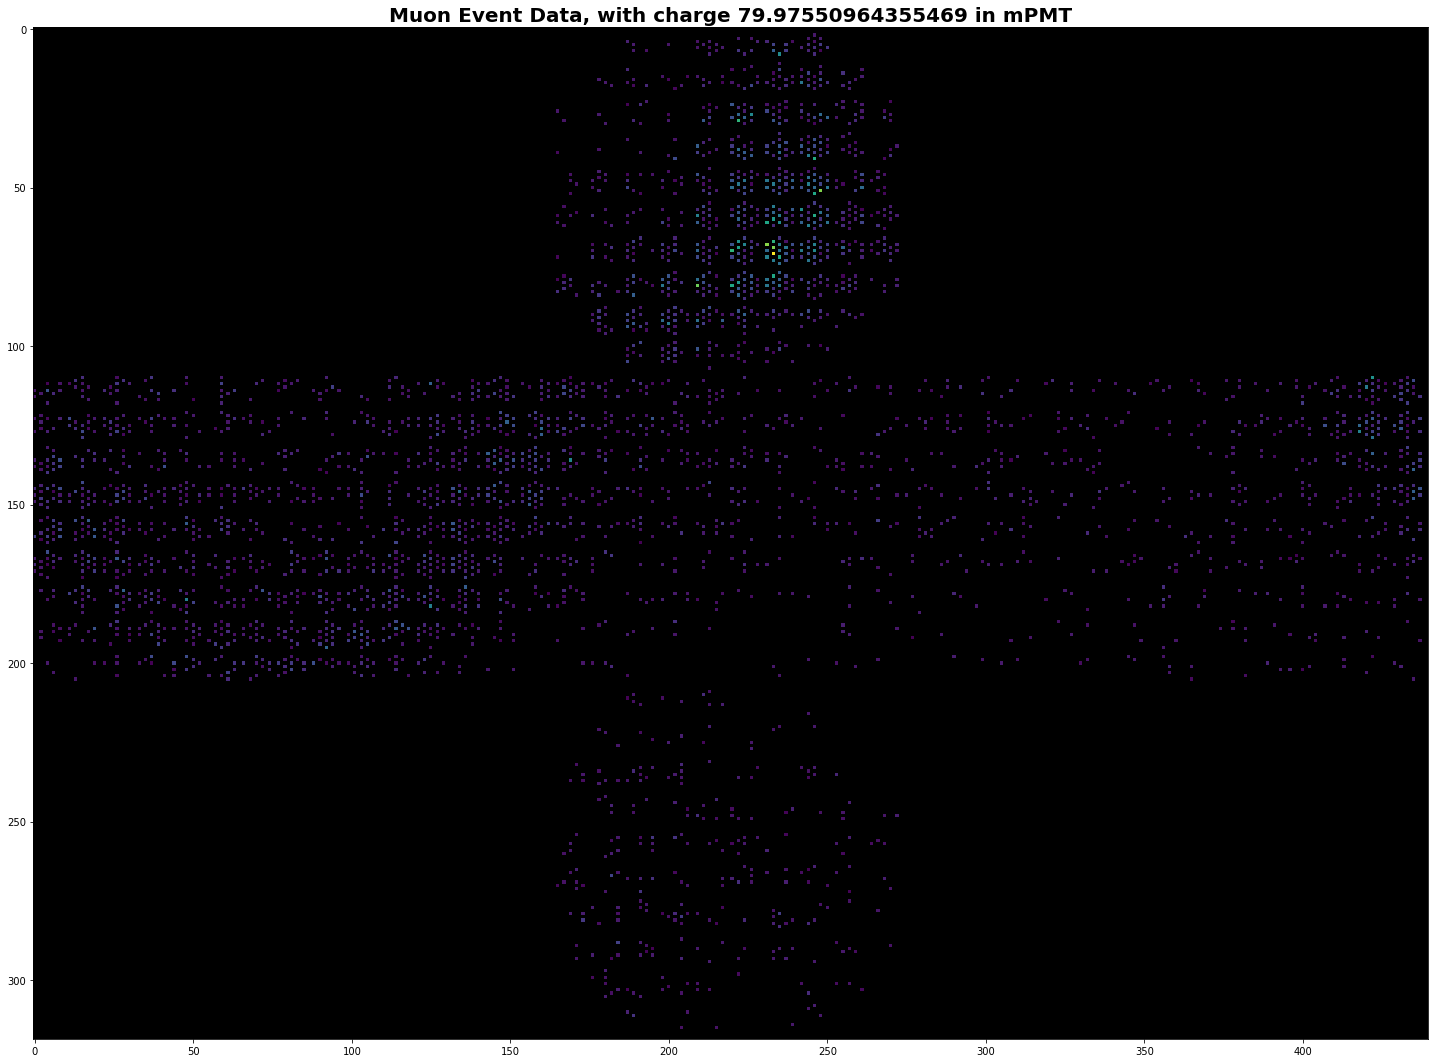

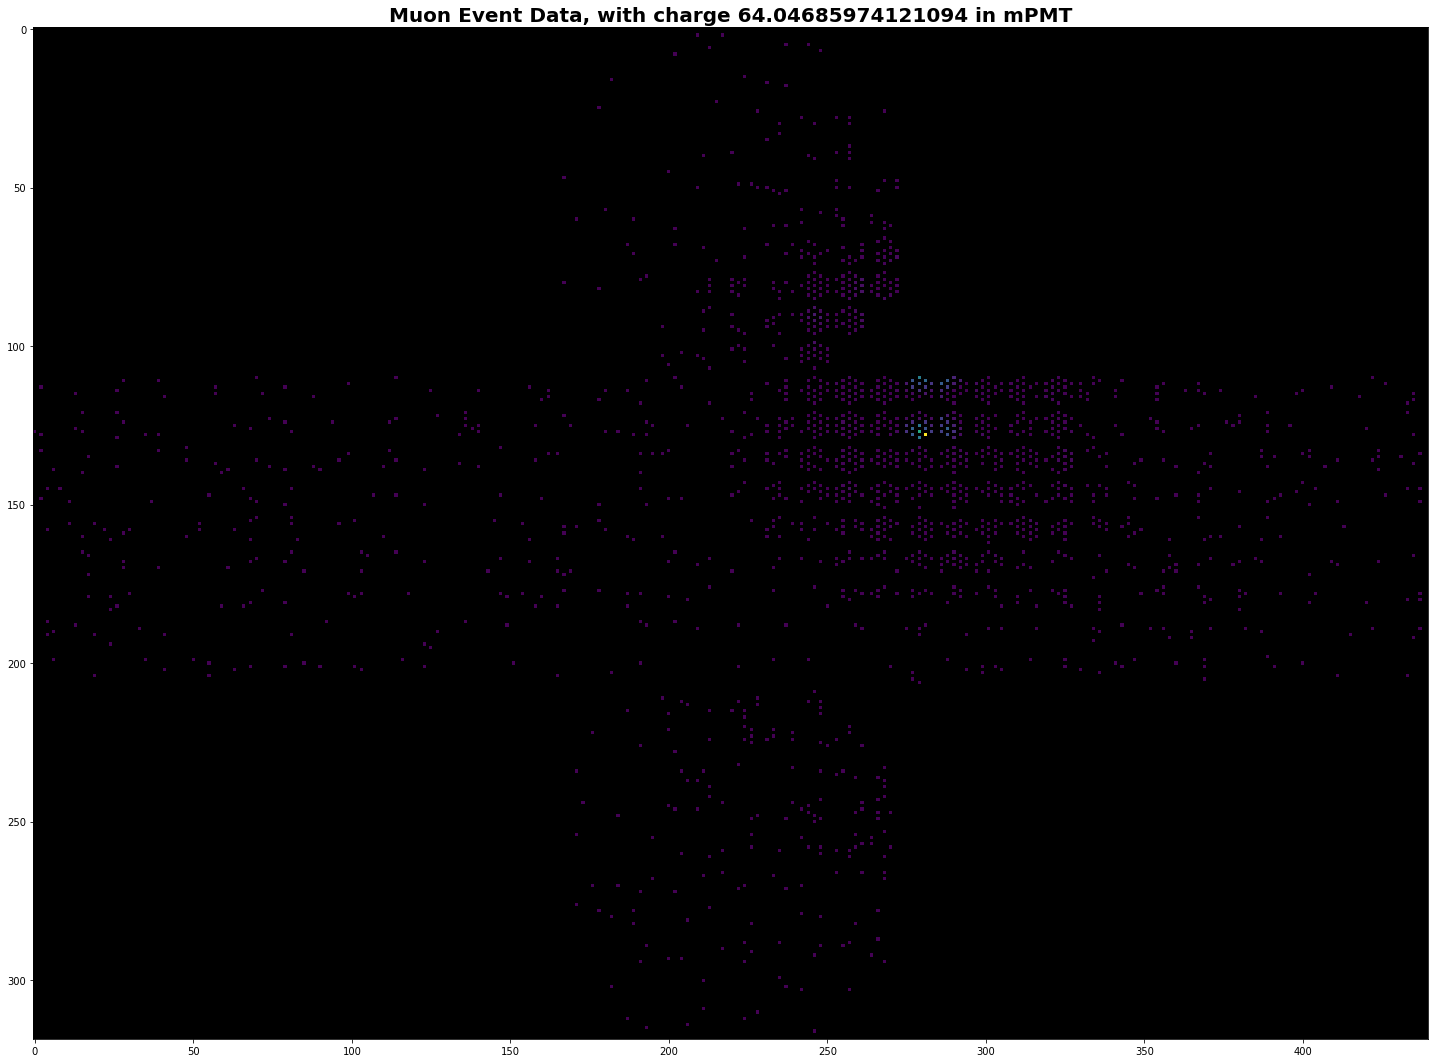

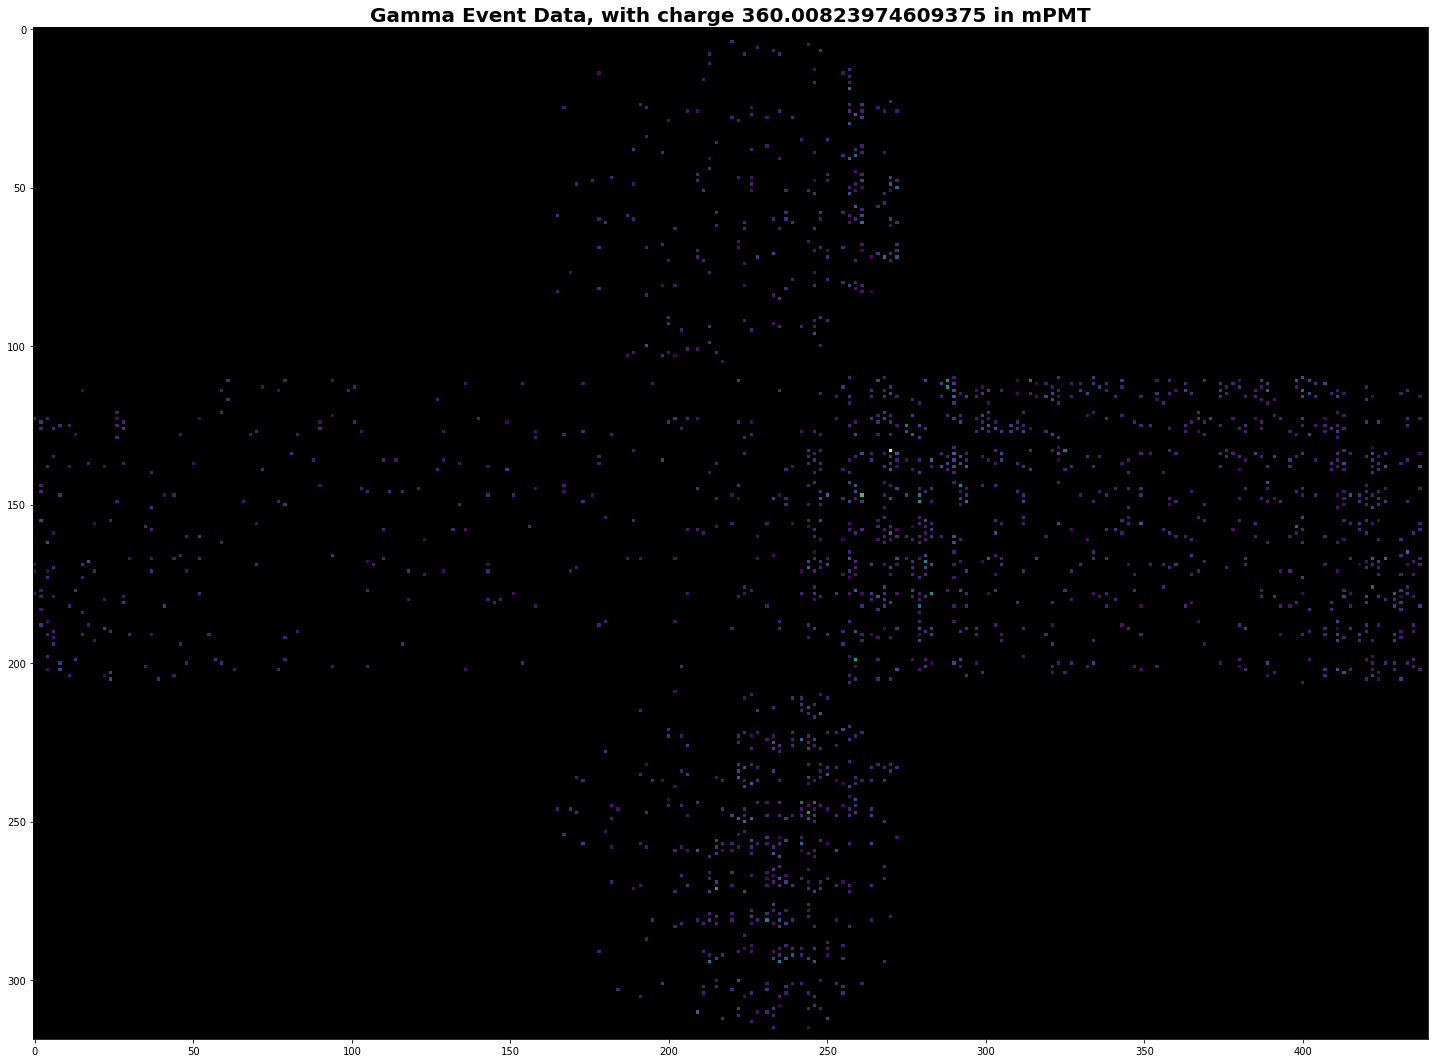

In [37]:
event_data_dict = {0:'Gamma', 1:'Electron', 2:'Muon'}

for event_index, event_charge in zip(sample_event_indices, sample_event_charges):
    event_data = get_event_data_from_index(event_index)
    event_label = dataset_info[0]['labels'][event_index]
    
    fig, axes = plt.subplots(1,1,figsize=(25,25),facecolor='w')
    ax = axes

    cmap = plt.cm.viridis
    cmap.set_bad(color='black')

    a = get_plot_array(event_data)
    a = np.ma.masked_where(a < 0.05, a)

    b = ax.imshow(a, 
              origin="upper",
              cmap=cmap)
    
    #fig.colorbar(b, cmap=cmap, ax=ax)

    ax.set_title('{} Event Data, with charge {} in mPMT'.format(event_data_dict[event_label], event_charge),fontsize=20,fontweight='bold')
    plt.show()

# Max PMT Charge

In [38]:
"""
total_charge = []

pbar = ProgressBar(widgets=['Calculating Max Charge for Training Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
            ' ', ETA()], maxval=len(train_idxs))

pbar.start()
for i in range(len(train_idxs)):
    pbar.update(i)
    
    item = train_idxs[i]
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]
    charge = hit_charge[start:stop]
    
    max_charge = np.max(charge)
    
    total_charge.append(max_charge)
pbar.finish()

dataset_info[0]['max_charge'] = np.array(total_charge)

np.savez('./new_dataset_data/training_set_max_charge.npz', max_charge = dataset_info[0]['max_charge'])
"""

"\ntotal_charge = []\n\npbar = ProgressBar(widgets=['Calculating Max Charge for Training Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n            ' ', ETA()], maxval=len(train_idxs))\n\npbar.start()\nfor i in range(len(train_idxs)):\n    pbar.update(i)\n    \n    item = train_idxs[i]\n    start = event_hits_index[item]\n    stop  = event_hits_index[item + 1]\n    charge = hit_charge[start:stop]\n    \n    max_charge = np.max(charge)\n    \n    total_charge.append(max_charge)\npbar.finish()\n\ndataset_info[0]['max_charge'] = np.array(total_charge)\n\nnp.savez('./new_dataset_data/training_set_max_charge.npz', max_charge = dataset_info[0]['max_charge'])\n"

In [39]:
"""
total_charge = []

pbar = ProgressBar(widgets=['Calculating Total Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(val_idxs))

pbar.start()
for i in range(len(val_idxs)):
    pbar.update(i)
    
    item = val_idxs[i]
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]
    charge = hit_charge[start:stop]
    
    max_charge = np.max(charge)
    
    total_charge.append(max_charge)
pbar.finish()

dataset_info[1]['max_charge'] = np.array(total_charge)

np.savez('./new_dataset_data/validation_set_max_charge.npz', max_charge=dataset_info[1]['max_charge'])
"""

"\ntotal_charge = []\n\npbar = ProgressBar(widgets=['Calculating Total Charge for Validation Set. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=len(val_idxs))\n\npbar.start()\nfor i in range(len(val_idxs)):\n    pbar.update(i)\n    \n    item = val_idxs[i]\n    start = event_hits_index[item]\n    stop  = event_hits_index[item + 1]\n    charge = hit_charge[start:stop]\n    \n    max_charge = np.max(charge)\n    \n    total_charge.append(max_charge)\npbar.finish()\n\ndataset_info[1]['max_charge'] = np.array(total_charge)\n\nnp.savez('./new_dataset_data/validation_set_max_charge.npz', max_charge=dataset_info[1]['max_charge'])\n"

In [40]:
dataset_info[0]['max_charge'] = np.load('./new_dataset_data/training_set_max_charge.npz',allow_pickle=True)['max_charge']
dataset_info[1]['max_charge'] = np.load('./new_dataset_data/validation_set_max_charge.npz',allow_pickle=True)['max_charge']

Bins:  [1.2690394e+00 9.9317039e+01 1.9736504e+02 2.9541302e+02 3.9346103e+02
 4.9150903e+02 5.8955701e+02 6.8760504e+02 7.8565302e+02 8.8370105e+02
 9.8174902e+02 1.0797970e+03 1.1778450e+03 1.2758931e+03 1.3739410e+03
 1.4719890e+03 1.5700370e+03 1.6680850e+03 1.7661331e+03 1.8641810e+03
 1.9622290e+03 2.0602771e+03 2.1583250e+03 2.2563730e+03 2.3544209e+03
 2.4524690e+03 2.5505171e+03 2.6485649e+03 2.7466130e+03 2.8446609e+03
 2.9427090e+03]


../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:906: Runt

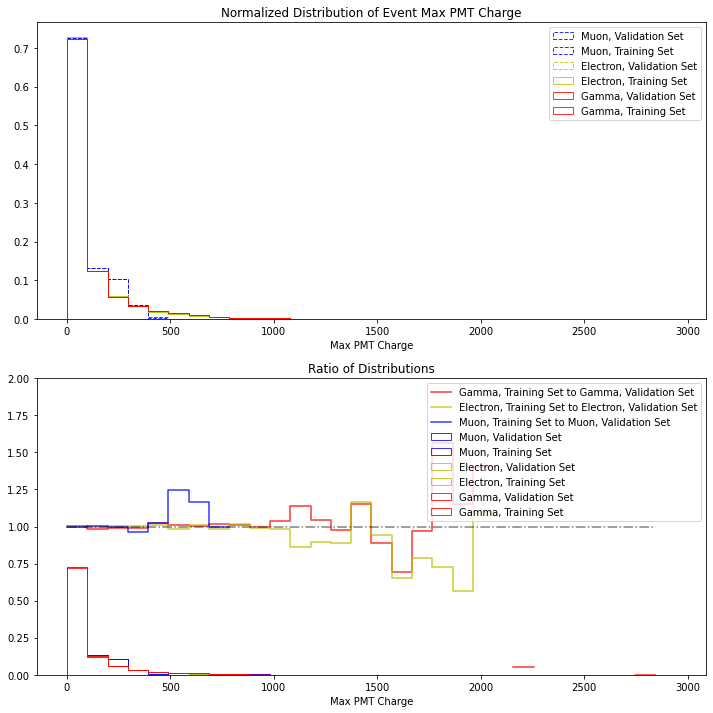

In [50]:
fig = plot_compare_dists([
                    dataset_info[0]['max_charge'][train_g_idxs], dataset_info[1]['max_charge'][val_g_idxs],
                    dataset_info[0]['max_charge'][train_e_idxs], dataset_info[1]['max_charge'][val_e_idxs],
                    dataset_info[0]['max_charge'][train_m_idxs], dataset_info[1]['max_charge'][val_m_idxs]],
                    bins=30,
                    numerator_dist_idxs   = [0,2,4],
                    denominator_dist_idxs = [1,3,5],
                    labels=['Gamma, Training Set', 'Gamma, Validation Set',
                            'Electron, Training Set', 'Electron, Validation Set',
                            'Muon, Training Set', 'Muon, Validation Set'],
                    ratio_range=[0,2],
                    title='Normalized Distribution of Event Max PMT Charge',
                    colors=['r','r','y','y','b','b'],
                    linestyle=['-','-','-','--','--','--'],
                    xlabel='Max PMT Charge',
                    verbose=True
                    )

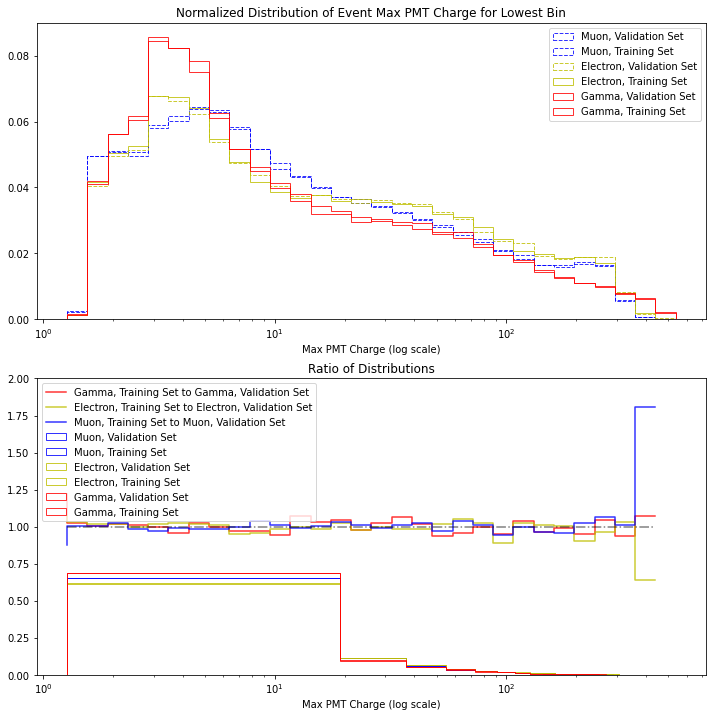

In [51]:
# Find all events in the leftmost bin
train_max_left_bin_bound = 1.4834103e+02
left_max_train_g_idxs = train_g_idxs[dataset_info[0]['total_charge'][train_g_idxs] < train_max_left_bin_bound]
left_max_train_e_idxs = train_e_idxs[dataset_info[0]['total_charge'][train_e_idxs] < train_max_left_bin_bound]
left_max_train_m_idxs = train_m_idxs[dataset_info[0]['total_charge'][train_m_idxs] < train_max_left_bin_bound]

val_max_left_bin_bound = 1.4834103e+02
left_max_val_g_idxs = val_g_idxs[dataset_info[1]['total_charge'][val_g_idxs] < val_max_left_bin_bound]
left_max_val_e_idxs = val_e_idxs[dataset_info[1]['total_charge'][val_e_idxs] < val_max_left_bin_bound]
left_max_val_m_idxs = val_m_idxs[dataset_info[1]['total_charge'][val_m_idxs] < val_max_left_bin_bound]


fig = plot_compare_dists([
                    dataset_info[0]['max_charge'][left_train_g_idxs], dataset_info[1]['max_charge'][left_val_g_idxs],
                    dataset_info[0]['max_charge'][left_train_e_idxs], dataset_info[1]['max_charge'][left_val_e_idxs],
                    dataset_info[0]['max_charge'][left_train_m_idxs], dataset_info[1]['max_charge'][left_val_m_idxs]],
                    bins=30,
                    numerator_dist_idxs   = [0,2,4],
                    denominator_dist_idxs = [1,3,5],
                    labels=['Gamma, Training Set', 'Gamma, Validation Set',
                            'Electron, Training Set', 'Electron, Validation Set',
                            'Muon, Training Set', 'Muon, Validation Set'],
                    ratio_range=[0,2],
                    title='Normalized Distribution of Event Max PMT Charge for Lowest Bin',
                    colors=['r','r','y','y','b','b'],
                    linestyle=['-','-','-','--','--','--'],
                    xlabel='Max PMT Charge (log scale)',
                    xscale='log'
                    )

# Distribution of Event Hit Types

In [46]:
"""
pbar = ProgressBar(widgets=['Calculating Event Hit Types. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))

pbar.start()
done=0
for dset in dataset_info:
    hit_types = []
    for i in range(dset['positions'].shape[0]):
        pbar.update(done + i)
        hit_types.append(event_hit_type(dset['positions'][i][0], dset['angles'][i]))
    dset['hit_types'] = hit_types
    done = done + dset['positions'].shape[0]
pbar.finish()

np.savez('./new_dataset_data/hit_types.npz', train_hit_types= dataset_info[0]['hit_types'],
                          val_hit_types  = dataset_info[1]['hit_types'],
                          test_hit_types = dataset_info[2]['hit_types'])
"""

"\npbar = ProgressBar(widgets=['Calculating Event Hit Types. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))\n\npbar.start()\ndone=0\nfor dset in dataset_info:\n    hit_types = []\n    for i in range(dset['positions'].shape[0]):\n        pbar.update(done + i)\n        hit_types.append(event_hit_type(dset['positions'][i][0], dset['angles'][i]))\n    dset['hit_types'] = hit_types\n    done = done + dset['positions'].shape[0]\npbar.finish()\n\nnp.savez('./new_dataset_data/hit_types.npz', train_hit_types= dataset_info[0]['hit_types'],\n                          val_hit_types  = dataset_info[1]['hit_types'],\n                          test_hit_types = dataset_info[2]['hit_types'])\n"

In [47]:
f = np.load('./new_dataset_data/dist_to_wall.npz', allow_pickle=True)

dataset_info[0]['d_to_wall'] = f['train_d_to_wall']
dataset_info[1]['d_to_wall'] = f['val_d_to_wall']
dataset_info[2]['d_to_wall'] = f['test_d_to_wall']

In [53]:
hit_type_dict = {'endcap': 0, 'barrel': 1}
f = np.load('./new_dataset_data/hit_types.npz', allow_pickle=True)

dataset_info[0]['hit_types'] = f['train_hit_types']
dataset_info[1]['hit_types'] = f['val_hit_types']
dataset_info[2]['hit_types'] = f['test_hit_types']

In [54]:
# Find all endcap events
endcap_train_idxs = dataset_info[0]['hit_types'] == hit_type_dict['endcap']
endcap_val_idxs   = dataset_info[1]['hit_types'] == hit_type_dict['endcap']
endcap_test_idxs  = dataset_info[2]['hit_types'] == hit_type_dict['endcap']

# Find all barrel events
barrel_train_idxs = dataset_info[0]['hit_types'] == hit_type_dict['barrel']
barrel_val_idxs   = dataset_info[1]['hit_types'] == hit_type_dict['barrel']
barrel_test_idxs  = dataset_info[2]['hit_types'] == hit_type_dict['barrel']

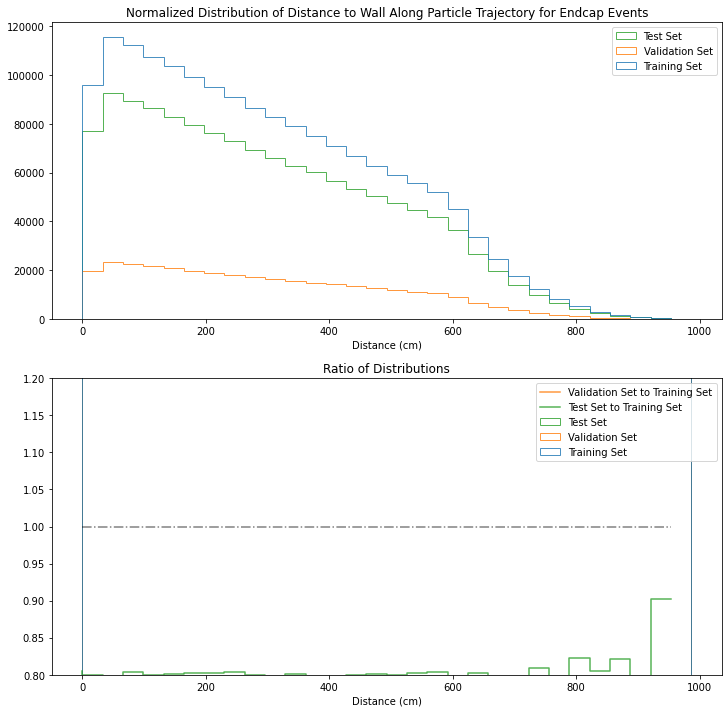

In [58]:
# Plot endcap distance to wall histogram
patches = plot_compare_dists([
                            dataset_info[0]['d_to_wall'][endcap_train_idxs],
                            dataset_info[1]['d_to_wall'][endcap_val_idxs],
                            dataset_info[2]['d_to_wall'][endcap_test_idxs]],
                            bins=30,
                            numerator_dist_idxs   = [1,2],
                            denominator_dist_idxs = [0,0],
                            labels=[data['name'] for data in dataset_info],
                            title='Normalized Distribution of Distance to Wall Along Particle Trajectory for Endcap Events',
                            ratio_range=[0.8,1.2],
                            xlabel='Distance (cm)',
                            normalized=False)


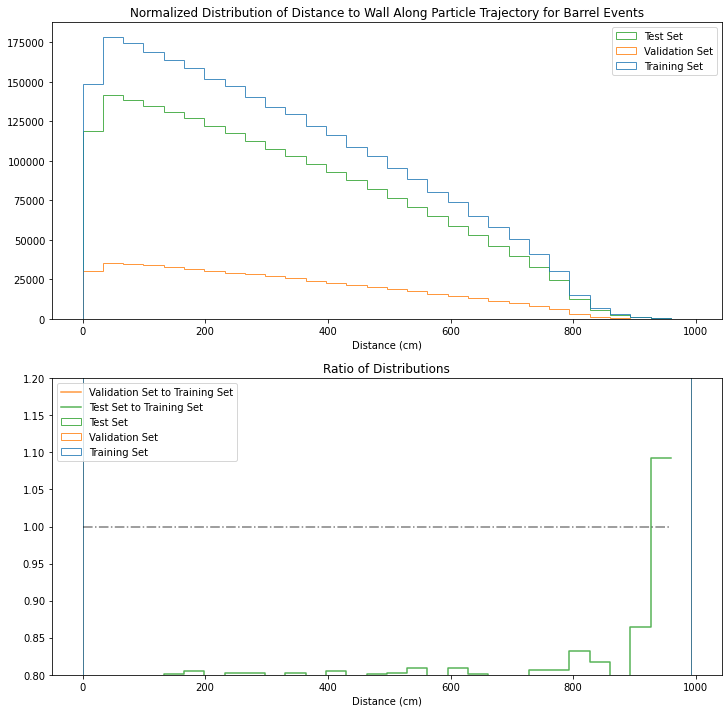

In [57]:
# Plot barrel distance to wall histogram
patches = plot_compare_dists([
                            dataset_info[0]['d_to_wall'][barrel_train_idxs],
                            dataset_info[1]['d_to_wall'][barrel_val_idxs],
                            dataset_info[2]['d_to_wall'][barrel_test_idxs]],
                            bins=30,
                            numerator_dist_idxs   = [1,2],
                            denominator_dist_idxs = [0,0],
                            labels=[data['name'] for data in dataset_info],
                            title='Normalized Distribution of Distance to Wall Along Particle Trajectory for Barrel Events',
                            ratio_range=[0.8,1.2],
                            xlabel='Distance (cm)',
                            normalized=False)
